In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
DATA_DIR='/content/drive/MyDrive/Colab Notebooks/mesh2matrix/mesh'
#old DATA_DIR='/content/drive/MyDrive/mesh'

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/mesh2matrix')

In [ ]:
#!pip install -r MeSH2Matrix/requirements.txt
!pip install livelossplot --quiet

     |████████████████████████████████| 1.6 MB 39.9 MB/s 


In [ ]:
from google.colab import drive
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import torchtext
from torch.utils.data import Dataset,DataLoader
#from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,f1_score
from livelossplot import PlotLosses
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import json
from pathlib import Path
import matplotlib

device = torch.device('cuda' if True and torch.cuda.is_available() else 'cpu')

NUM_CLASSES=5
BATCH_SIZE=128

MeSH Dataset Class...

In [ ]:
class MESHDataset(Dataset):
    def __init__(self,numpy_file,label_file):
     
      try:
        self.data= np.load(numpy_file)
        self.labels = np.load(label_file)
      except Exception as err:
        raise Exception(f'ERROR OPENING FILES: {numpy_file} | {label_file}. See Error below. \n {err}')  
       
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self, idx):
        #Get the element with `idx`
        #Output an 89*89 matrix
        return np.expand_dims(self.data[idx], axis=0), self.labels[idx]

Baseline Model...

In [ ]:
class InceptionModel(nn.Module):

    def __init__(self, matrix_size=89):
      #Idea
      """
      ConvNet -> ConvNet -> Flatten ->  Dense => Class 
      """
      super(InceptionModel, self).__init__()
      self.layer1 = nn.Sequential(
          nn.Conv2d(1, 128, kernel_size=3, stride=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Conv2d(128,64, kernel_size=3, stride=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Conv2d(64,32, kernel_size=3, stride=1),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2)
          )
      self.layer2 = nn.Sequential(
          nn.Conv2d(32, 16, kernel_size=3, stride=1),
          nn.BatchNorm2d(16),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2)
        )
      
      self.drop_out = nn.Dropout()
      self.fc = nn.Sequential(
          #nn.Linear(12800, 5000),
          #nn.ReLU(),
          #nn.Linear(5000, 1000),
          #nn.ReLU(),
          nn.Linear(2592,1024),
          nn.ReLU(),
          nn.Linear(1024,500),
          nn.ReLU(),
          nn.Linear(500,NUM_CLASSES)
      )
    def forward(self, x):

        #Expecting `x` to be an 89*89 matrix. 
        #print(f'X original shape: {x.shape}')
        x=self.layer1(x)
        #x = self.layer2(x)
        x = x.reshape(x.size(0), -1)
        #print(f'Flattened X has shape: {x.shape}')
        x=self.drop_out(x)
        x=self.fc(x)
        #out = F.log_softmax(x) #Don't use softmax here since we use torch.nn.CrossEntropyLoss. 
        return x

Creating the dataloaders...

In [ ]:
train_dataset = MESHDataset(os.path.join(DATA_DIR,'output/train.npy'),os.path.join(DATA_DIR,'output/grouped_train_labels.npy'))
dev_dataset = MESHDataset(os.path.join(DATA_DIR,'output/dev.npy'),os.path.join(DATA_DIR,'output/grouped_dev_labels.npy'))
test_dataset = MESHDataset(os.path.join(DATA_DIR,'output/test.npy'),os.path.join(DATA_DIR,'output/grouped_test_labels.npy'))


train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Creating the model...


In [ ]:
model = InceptionModel().to(device)
model

InceptionModel(
  (layer1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(k

Training Configuration...

In [ ]:
import sys
def compute_accuracy(pred,target):  
  acc = (target == pred.argmax(dim=1)).float().detach().numpy()
  return float(100 * acc.sum() / len(acc))


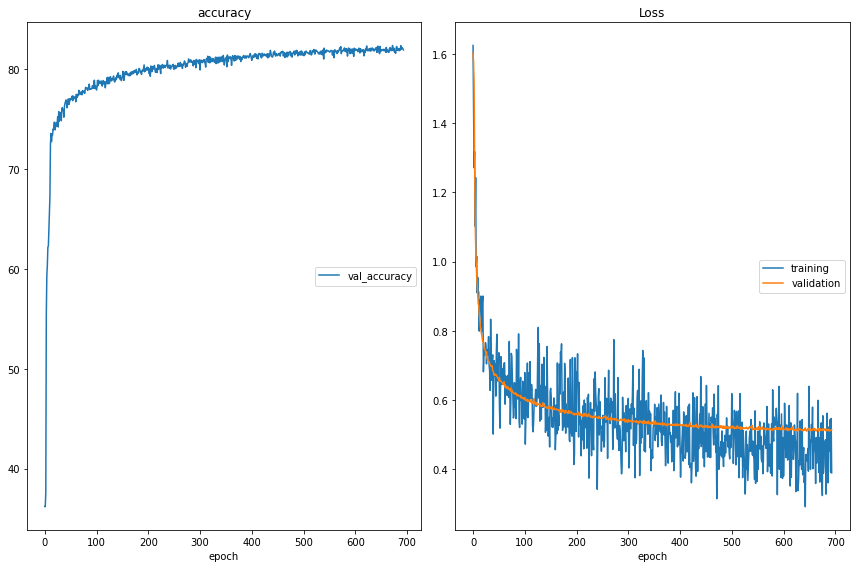

accuracy
	val_accuracy     	 (min:   36.188, max:   82.389, cur:   81.944)
Loss
	training         	 (min:    0.291, max:    1.625, cur:    0.389)
	validation       	 (min:    0.510, max:    1.602, cur:    0.514)


In [ ]:
#Define criterion: Categorical cross entropy
criterion = nn.CrossEntropyLoss()
#Define optimizer. For now, Adam
optimizer = optim.Adam(model.parameters(), lr=1e-5)

PRINT_FREQ = 5
DO_VALIDATION_STEP=30
NUM_EPOCHS=1500
PATIENCE=50

PATH=os.path.join(DATA_DIR,'output/best_model_cnn_best_128_5classes')

if os.path.isfile(PATH):
  model.load_state_dict(torch.load(PATH))

best_acc = 0

liveloss = PlotLosses()
patience=0


for epoch in range(NUM_EPOCHS):
  for i,(features, label) in enumerate(train_dataloader):
    features, label = features.to(device), label.to(device)
    optimizer.zero_grad()
    pred = model(features.float())
    loss = criterion(pred,label)

   
    
    loss.backward()
    optimizer.step()

    if i%DO_VALIDATION_STEP==0:
      #Do validation
      model.eval()
      val_losses=[]
      val_acc_list=[]
      for val_features, val_label in dev_dataloader:
         val_features, val_label = val_features.to(device), val_label.to(device)
         val_pred = model(val_features.float())
         val_loss = criterion(val_pred,val_label)
         val_losses.append(val_loss.item())
         val_acc_list.append(compute_accuracy(val_pred.cpu(),val_label.cpu()))

      val_loss_ = np.mean(val_losses) 
      val_acc = np.mean(val_acc_list)
      if val_acc> best_acc:
        best_acc=val_acc
        patience=0
        #Save model weights
        torch.save(model.state_dict(), PATH)
      else:
        patience+=1
      if patience >= PATIENCE:
        print('Ending due to early stopping...')
        break    
      
      logs={'loss':loss.item(),'val_loss':val_loss_,'val_accuracy':val_acc}
      liveloss.update(logs)
      liveloss.send()  
      model.train()  


Compute test metrics... 

In [ ]:
from sklearn.metrics import accuracy_score
def compute_accuracy(pred, target):
  return target.detach().numpy(), pred.argmax(-1).detach().numpy()

In [ ]:

PATH=os.path.join(DATA_DIR,'output/best_model_cnn_best_128_5classes')

if os.path.isfile(PATH):
  model.load_state_dict(torch.load(PATH, map_location='cpu'))


In [ ]:
model.eval()

labels, preds = [], []
for test_features, test_label in test_dataloader:
  # print(test_features.size())
  test_features, test_label = test_features.to(device), test_label.to(device)
  test_pred = model(test_features.float())
  true, predictions = compute_accuracy(test_pred.cpu(),test_label.cpu())
  labels += true.tolist()
  preds += predictions.tolist()
print(f'Best CNN Model Accuracy with 5 classes:{accuracy_score(labels, preds)}')
print("Best CNN Model Weighted F1-Score with 5 classes: {}".format(f1_score(labels, preds, average='weighted')))

Best CNN Model Accuracy with 5 classes:0.8277383258015925
Best CNN Model Weighted F1-Score with 5 classes: 0.826093641861537


# Confusion Matrix

In [ ]:
confusion= confusion_matrix(labels, preds)
print(confusion)

[[1869    7   14  125  230]
 [  16   36    0    6   66]
 [  93    0 1716   18   64]
 [ 225    5    5 2822   80]
 [ 366   19   98  164 1250]]


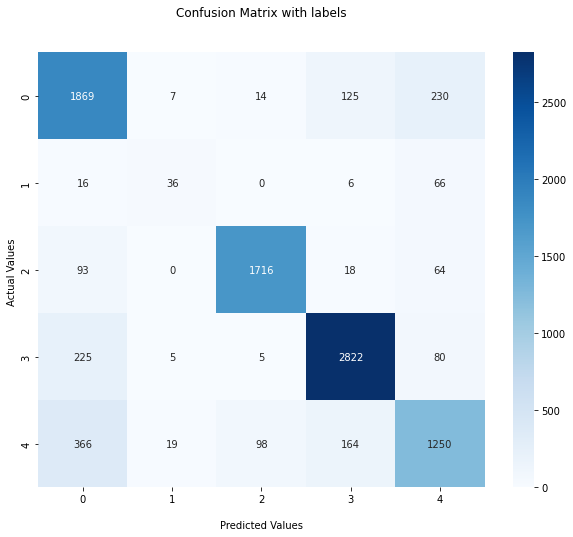

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,8))
ax = sns.heatmap(confusion, annot=True, cmap='Blues', fmt='d')
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([0,1,2,3,4])
ax.yaxis.set_ticklabels([0,1,2,3,4])
## Save and display the visualization of the Confusion Matrix.
plt.savefig('/content/drive/MyDrive/Colab Notebooks/mesh2matrix/MeSH2Matrix/output/CNN5.png')
plt.show()

In [ ]:
data = pd.DataFrame(confusion, index=[0,1,2,3,4], columns=[0,1,2,3,4])
data.head()

,0,1,2,3,4
0,1869,7,14,125,230
1,16,36,0,6,66
2,93,0,1716,18,64
3,225,5,5,2822,80
4,366,19,98,164,1250


In [ ]:
data.to_csv('/content/drive/MyDrive/Colab Notebooks/mesh2matrix/MeSH2Matrix/output/CNN5.csv')

# Feature Analysis with Integrated Gradient

In [ ]:
# defining the functions

def move_to_device(batch):
    if torch.cuda.is_available():
        batch = batch.to("cuda")
    return batch


def compute_integrated_gradient(batch_x, batch_blank, model, idx):
    mean_grad = 0
    n = 100

    for i in range(1, n + 1):
        x = batch_blank + i / n * (batch_x - batch_blank)
        x.requires_grad = True
        y = model(x)[0, idx]
        (grad,) = torch.autograd.grad(y, x)
        mean_grad += grad / n

    integrated_gradients = (batch_x - batch_blank) * mean_grad

    return integrated_gradients


def plot_images(
    images,
    titles,
    output_path,
):
    fig, axs = plt.subplots(1, len(images))

    fig.set_figheight(10)
    fig.set_figwidth(16)

    for i, (title, img) in enumerate(zip(titles, images)):
        axs[i].imshow(img, cmap=matplotlib.cm.gray)
        axs[i].set_title(title)

    fig.tight_layout()
    plt.savefig(output_path)

# # Performing IG for 1 sample set.

In [ ]:
len(test_dataset)

9294

In [ ]:
for  idx, a in enumerate(test_dataset):
    x, y_idx = a[0], a[1]

In [ ]:
for i , (test_features, test_label) in enumerate(test_dataloader):
    if test_label[i] == 1:
        x, y_idx = test_features[i], test_label[i]
        break

In [ ]:
x.shape

torch.Size([1, 89, 89])

In [ ]:
# Read images
input_image_x = x
input_image_blank = Image.new("L", (89,89))

input_image_blank = transforms.ToTensor()(input_image_blank)

# Preprocess inputs
input_tensor_x = torch.from_numpy(input_image_x)
batch_x = input_tensor_x.unsqueeze(0)

input_tensor_blank = input_image_blank
batch_blank = input_tensor_blank.unsqueeze(0)

batch_x = move_to_device(batch_x)
batch_blank = move_to_device(batch_blank)

# Integrated gradient computation
integrated_gradients = compute_integrated_gradient(batch_x.float(), batch_blank.float(), model, y_idx)

resized_batch_x = torch.from_numpy(input_image_x)


# Change to channel last
integrated_gradients = integrated_gradients.permute(0, 1, 2)
batch_x =batch_x.permute(0, 1, 2)
resized_batch_x = resized_batch_x.permute(0, 1, 2)

# Squeeze + move to cpu

np_integrated_gradients = integrated_gradients[0, :, :].cpu().data.numpy()

resized_x = resized_batch_x[0, :, :].cpu().data.numpy()

np_integrated_gradients = np.fabs(np_integrated_gradients)

# normalize amplitudes

np_integrated_gradients = np_integrated_gradients / np.max(np_integrated_gradients)

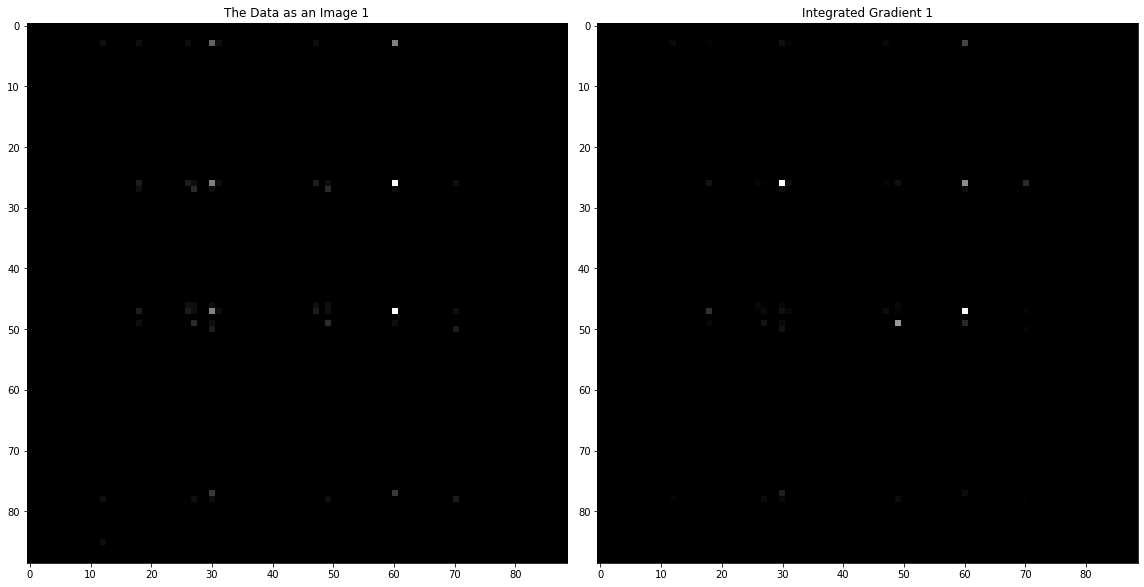

In [ ]:
# Overlay integrated gradient with image
images = [resized_x, np_integrated_gradients]
titles = ["The Data as an Image 1", "Integrated Gradient 1"]
plot_images(images, titles, "1" + "cat.png".split("/")[-1])

# # Performing IG for 8080 samples

In [ ]:
maxdf = pd.DataFrame()

for  idx, a in enumerate(test_dataset):
    if idx > 8080:
        print ('done')
        break
    x, y_idx = a[0], a[1]


    # Read images
    input_image_x = x
    input_image_blank = Image.new("L", (89,89))
    input_image_blank = transforms.ToTensor()(input_image_blank)

    # Preprocess inputs
    input_tensor_x = torch.from_numpy(input_image_x)
    batch_x = input_tensor_x.unsqueeze(0)

    input_tensor_blank = input_image_blank
    batch_blank = input_tensor_blank.unsqueeze(0)

    batch_x = move_to_device(batch_x)
    batch_blank = move_to_device(batch_blank)

    # Integrated gradient computation

    integrated_gradients = compute_integrated_gradient(batch_x.float(), batch_blank.float(), model, y_idx)  
    integrated_gradient = integrated_gradients.squeeze().cpu().data.numpy().reshape(1, -1)

    #writing to df
    minidf = pd.DataFrame({'data_id':idx, 'features':list(range(len(integrated_gradient[0]))), 'int_gra':integrated_gradient[0], 'label': y_idx})
    maxdf = pd.concat([maxdf, minidf])
    

maxdf.to_csv('int_g_df_CNN.csv', index=False)

done


In [ ]:
maxdf

,data_id,features,int_gra,label
0,0,0,0.0,3
1,0,1,0.0,3
2,0,2,0.0,3
3,0,3,0.0,3
4,0,4,-0.0,3
...,...,...,...,...
7916,0,7916,0.0,3
7917,0,7917,0.0,3
7918,0,7918,0.0,3
7919,0,7919,0.0,3


In [ ]:
len(maxdf)

64009601